# Making Predictions

# Imports and connection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

C:\Users\sebar\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\sebar\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# Understanding the Data

In [3]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

## Complete OLS

### 1. Converting certain features to dummies

In [4]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

### 2. Defining X and Y values

In [5]:
Y = house_prices_df['saleprice']

X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

### 3. Splitting dataset into train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

print('The number of observations in the X training set is {}.'.format(X_train.shape[0]))
print('The number of observations in the X test set is {}.'.format(X_test.shape[0]))

The number of observations in the X training set is 1168.
The number of observations in the X test set is 292.


### 4. Individually adding constant to X_train

In [7]:
X_train = sm.add_constant(X_train)

### 5. Fitting regression line

In [8]:
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        22:27:53   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.039e+05   2.06e+04     -5.037      0.000   -1.44e+05   -6.34e+04
overallqual  2.433e+04   1244.706     19.548      0.000    2.19e+04    2.68e+04
grlivarea      43.3745      2.745     15.800      0.000      37.988      48.760
garagecars   1.407e+04   3409.600      4.126      0.000    7379.047    2.08e+04
garagearea     17.5210     11.560      1.516      0.130      -5.161      40.203
totalbsmtsf    23.4504      3.183      7.368      0.000      17.206      29.695
mszoning_FV  1.933e+04    1.5e+04      1.289      0.198   -1.01e+04    4.88e+04
mszoning_RH  7305.5078   1.72e+04      0.426      0.670   -2.63e+04     4.1e+04
mszoning_RL  2.429e+04   1.39e+04      1.747      0.081   -2983.478    5.16e+04
mszoning_RM  2864.3070   1.41e+04      0.203      0.839   -2.48e+04    3.05e+04
street_Pave -8177.6681   1.74e+04     -0.470      0.639   -4.23e+04     2.6e+04
==============================================================================
Omnibus:                      355.774   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30190.746
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                      27.895   Cond. No.                     5.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 6. Running a prediction

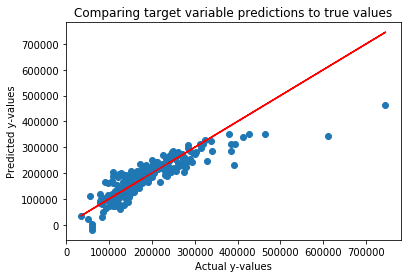

Mean absolute error of our prediction: 25546.80382858886.
Mean squared error of our prediction: 1559083821.9730694.
Root mean squared error of our prediction: 39485.2354934483.
Mean absolute percentage error of our prediction: 15.551420347537784.


In [9]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual y-values')
plt.ylabel('Predicted y-values')
plt.title('Comparing target variable predictions to true values')
plt.show()

print('Mean absolute error of our prediction: {}.'.format(mean_absolute_error(y_test, y_preds)))
print('Mean squared error of our prediction: {}.'.format(mse(y_test, y_preds)))
print('Root mean squared error of our prediction: {}.'.format(rmse(y_test, y_preds)))
print('Mean absolute percentage error of our prediction: {}.'.format(np.mean(np.abs((y_test - y_preds)/y_test)) *100))

* It seems like our model predicts lower values of salesprice better than higher values. Still, the lower values could be closer to our target value plotted line.
* Let's alter some parameters and run another predictive model to compare the two models.

### Adding square-footage summation feature and interaction between it and overall home quality

In [10]:
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

Y = np.log1p(house_prices_df['saleprice'])

# 'log1p': Nani!?!?!

X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'totalsf', 'int_over_sf'] + dummy_column_names]

X = X.drop(columns=['garagearea', 'mszoning_FV', 'mszoning_RH', 'mszoning_RM', 'street_Pave'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

print('The number of observations in the X training set is {}.'.format(X_train.shape[0]))
print('The number of observations in the X test set is {}.'.format(X_test.shape[0]))

X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

The number of observations in the X training set is 1168.
The number of observations in the X test set is 292.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     769.4
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        22:27:54   Log-Likelihood:                 432.34
No. Observations:                1168   AIC:                            -848.7
Df Residuals:                    1160   BIC:                            -808.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.0440      0.056    178.299      0.000       9.934      10.155
overallqual     0.2016      0.009     21.902      0.000       0.184       0.220
grlivarea   -1.378e-05   9.51e-05     -0.145      0.885      -0.000       0.000
garagecars      0.1053      0.009     12.192      0.000       0.088       0.122
totalbsmtsf    -0.0001   9.84e-05     -1.075      0.283      -0.000    8.73e-05
totalsf         0.0004   9.97e-05      4.053      0.000       0.000       0.001
int_over_sf -2.727e-05   3.02e-06     -9.032      0.000   -3.32e-05   -2.13e-05
mszoning_RL     0.1348      0.013     10.696      0.000       0.110       0.160
==============================================================================
Omnibus:                      306.585   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1703.080
Skew:                          -1.094   Prob(JB):                         0.00
Kurtosis:                       8.496   Cond. No.                     2.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* This regression model gives us a higher R-squared reading, which indicated there is less variance in the target variable left unexplained by our model.
* This model also has much lower (negative?) AIC and BIC values.
* This would seem to indicate that our second regression model has better goodness of fit than our first regression model. Let's take this bad boy for a spin.

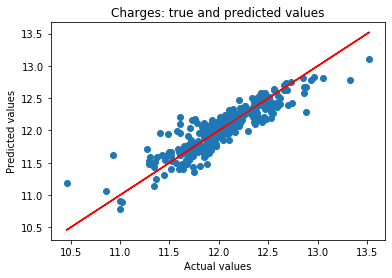

Mean absolute error of our prediction: 0.13082670884696426.
Mean squared error of our prediction: 0.03166749698233758.
Root mean squared error of our prediction: 0.17795363717085858.
Mean absolute percentage error of our prediction: 1.0941382988296313.


In [11]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Charges: true and predicted values')
plt.show()

print('Mean absolute error of our prediction: {}.'.format(mean_absolute_error(y_test, y_preds)))
print('Mean squared error of our prediction: {}.'.format(mse(y_test, y_preds)))
print('Root mean squared error of our prediction: {}.'.format(rmse(y_test, y_preds)))
print('Mean absolute percentage error of our prediction: {}.'.format(np.mean(np.abs((y_test - y_preds)/y_test)) *100))

This second regression model has much lower error term metrics. In reference to the scatter graph, it seems to much more uniformly give good predictions of actual salesprice values. We can conclude this regression model has much better predictive performance than our first one.